In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from openpifpaf_action_prediction import utils
from openpifpaf_action_prediction import voc_eval
from openpifpaf_action_prediction import datasets
import matplotlib.pyplot as plt
import glob
import os
import copy
from collections import defaultdict
from sklearn import linear_model
from sklearn import neural_network
from sklearn import model_selection
import pandas as pd

In [3]:
set_dir = 'data/voc2012/image_sets/action'
set_name = 'val'
anns_dir = 'data/voc2012/annotations'
voc_devkit_dir = '/Users/guarin/data_science/semester_project/VOCdevkit'

In [4]:
train_files = glob.glob(f'outputs/voc_03_271/train_raw_epoch400/*json')
train_pred_anns = dict(voc_eval.load_json(file) for file in train_files)
val_files = glob.glob(f'outputs/voc_03_271/val_raw_epoch400/*json')
val_pred_anns = dict(voc_eval.load_json(file) for file in val_files)

In [5]:
all_anns = voc_eval.load_eval_anns(anns_dir)
train_ids = set(np.loadtxt(os.path.join(set_dir, f"train.txt"), dtype=str))
val_ids = set(np.loadtxt(os.path.join(set_dir, f"val.txt"), dtype=str))
train_eval_anns = {
    file[:-4]: anns for file, anns in all_anns.items() if file[:-4] in train_ids
}
val_eval_anns = {
    file[:-4]: anns for file, anns in all_anns.items() if file[:-4] in val_ids
}

In [6]:
def eval_(anns, eval_anns, set_name):
    return voc_eval.voc_eval(pred_anns=anns, method='bbox', threshold=0.3, set_name=set_name, temp_dir='temp_dir', set_dir=set_dir, eval_anns=eval_anns, voc_devkit_dir=voc_devkit_dir, return_matcher=True)

def apply_strategy(anns, strategy_fun):
    new_anns = dict()
    for file, file_anns in anns.items():
        new_anns[file] = []
        for a in file_anns:
            a = copy.deepcopy(a)
            probability_fields = np.array(a['action_probability_fields']).astype(float)
            probabilities = strategy_fun(a, probability_fields)
            a['action_probabilities'] = probabilities
            new_anns[file].append(a)
    return new_anns

def mean_strategy(ann, probability_fields):
    probabilities = [
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ]
    if len(probabilities) > 0:
        probabilities = np.nanmean(
            np.array(probabilities), (0, 2, 3)
        ).tolist()
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def point_mean(ann):
    probability_fields = np.array(ann['action_probability_fields']).astype(float)
    probabilities = []
    for i, p in enumerate(probability_fields):
        if (p.size > 0) and not np.isnan(p).all():
            probabilities.append(np.nanmean(p, (1, 2)))
        else:
            probabilities.append(np.full(p.shape[0], np.nan, dtype=float))
    return probabilities

def max_strategy(ann, probability_fields):
    probabilities = [
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ]
    if len(probabilities) > 0:
        probabilities = np.nanmax(
            np.array(probabilities), (0, 2, 3)
        ).tolist()
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def mean_strategy(ann, probability_fields):
    probabilities = [
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ]
    if len(probabilities) > 0:
        probabilities = np.nanmean(
            np.array(probabilities), (0, 2, 3)
        ).tolist()
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def min_strategy(ann, probability_fields):
    probabilities = [
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ]
    if len(probabilities) > 0:
        probabilities = np.nanmin(
            np.array(probabilities), (0, 2, 3)
        ).tolist()
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def median_strategy(ann, probability_fields):
    probabilities = [
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ]
    if len(probabilities) > 0:
        probabilities = np.nanmedian(
            np.array(probabilities), (0, 2, 3)
        ).tolist()
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def weighted_mean_strategy(ann, probability_fields):
    probabilities = np.array([
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ])
    if len(probabilities) > 0:
        side_length = probabilities.shape[2]
        factor = np.ones((side_length, side_length))
        for i in range(side_length // 2 + 1):
            factor[i:-i, i:-i] += 1
        means = []
        for kp_prob in probabilities:
            kp_factor = factor.copy()
            kp_factor[np.isnan(kp_prob[0])] = 0.0
            kp_factor = kp_factor / kp_factor.sum()
            kp_mean = np.nansum(kp_factor * kp_prob, (1, 2))
            means.append(kp_mean)
        probabilities = np.mean(means, 0)
        
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

def center_strategy(ann, probability_fields):
    probabilities = np.array([
        p for p in probability_fields if (p.size > 0) and not np.isnan(p).all()
    ])
    if len(probabilities) > 0:
        side_length = probabilities.shape[-1]
        assert side_length > 0
        radius = side_length // 2
        probabilities = np.nanmean(probabilities[:, :, radius:radius+1, radius:radius+1], (0, 2, 3))
        probabilities = [p if p != np.nan else None for p in probabilities]
    else:
        probabilities = [None] * probability_fields.shape[0]
    return probabilities

## Decoding Strategies

In [7]:
strategies = {
    'min': min_strategy,
    'max': max_strategy,
    'median': median_strategy,
    'mean': mean_strategy,
    'weighted_mean': weighted_mean_strategy,
    'center': center_strategy,
}

pred_anns = {
    'train': train_pred_anns,
    'val': val_pred_anns
}

eval_anns = {
    'train': train_eval_anns,
    'val': val_eval_anns
}

In [8]:
results = {}
for set_ in ['train', 'val']:
    for name, strategy in strategies.items():
        anns = apply_strategy(pred_anns[set_], strategy)
        results[(set_, name)] = eval_(anns, eval_anns[set_], set_)

/Users/guarin/data_science/semester_project/pifpaf_plugins/openpifpaf_vcoco/env/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: Mean of empty slice


In [10]:
def result_df(results):
    columns = ['set', 'strategy', 'mAP', 'mAP matched']
    rows = []
    for (set_, name), (all_result, matched_result, _) in results.items():
        rows.append([set_, name, all_result[0], matched_result[0]])
    df = pd.DataFrame(rows, columns=columns)
    df = df.sort_values(['set', 'mAP'])
    df = df.reset_index(drop=True)
    return df

In [11]:
result_df(results)

,set,strategy,mAP,mAP matched
0,train,min,0.837629,0.851216
1,train,max,0.943803,0.959212
2,train,median,0.962038,0.977801
3,train,weighted_mean,0.963164,0.978928
4,train,mean,0.964042,0.979827
5,train,center,0.964150,0.979935
6,val,min,0.685299,0.693996
7,val,max,0.809548,0.820199
8,val,median,0.838892,0.850147
9,val,weighted_mean,0.842399,0.853709


In [12]:
train_matcher = results[('train', 'mean')][-1]

In [13]:
train_probabilities = np.array([point_mean(a[1]) for a in train_matcher.inner_matches()])
train_labels = np.array([a[0]['action_labels'] for a in train_matcher.inner_matches()])

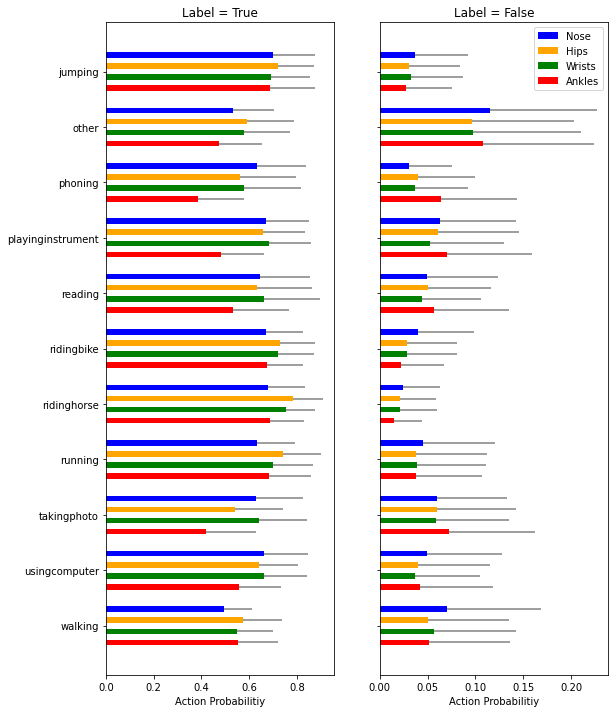

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 12))
colors = ['blue', 'orange', 'green', 'red']
for i, action in enumerate(datasets.voc2012.ACTIONS):
    t_preds = train_probabilities[train_labels[:, i] == 1][..., i]
    f_preds = train_probabilities[train_labels[:, i] == 0][..., i]

    for ax, preds in zip([ax1, ax2], [t_preds, f_preds]):
        nose = preds[:, 0]
        hips = preds[:, 1]
        wrists = preds[:, 2:4]
        ankles = preds[:, 4:6]
        for j, (part, color) in enumerate(zip([nose, hips, wrists, ankles], colors)):
            width = [np.nanmean(part)]
            xerr = [[0.0], [np.nanstd(part)]]
            ax.barh([-i - j/5], width=width, xerr=xerr, height=0.1, color=color, ecolor='gray')
            
ax1.set_yticks(ticks=-np.arange(11) - 0.3)
ax1.set_yticklabels(labels=datasets.voc2012.ACTIONS)
ax2.legend(['Nose', 'Hips', 'Wrists', 'Ankles'])
ax1.set_title('Label = True')
ax2.set_title('Label = False')
ax1.set_xlabel('Action Probabilitiy')
ax2.set_xlabel('Action Probabilitiy')
plt.savefig('point_action_correlation.png')
plt.show();

In [15]:
def field_stats(a):
    probability_fields = np.array(a['action_probability_fields']).astype(float)
    shape = probability_fields.shape
    stats = np.full((shape[0], 4, shape[1]), fill_value=-1.0)
    for i, p in enumerate(probability_fields):
        if (p.size == 0) or np.isnan(p).all():
            continue
        else:
            stats[i, 0] = np.nanmax(p, (1, 2))
            stats[i, 1] = np.nanmin(p, (1, 2))
            stats[i, 2] = np.nanmean(p, (1, 2))
            stats[i, 3] = np.nanmedian(p, (1, 2))
    return stats

def models_strategy(models, mean=None, std=None, normalize=False):
    def inner(ann, probability_fields):
        probabilities = []
        x = np.array(field_stats(ann)).flatten()
        x[np.isnan(x)] = -1
        if normalize:
            x = (x - mean) / std
        for model in models:
            probabilities.append(model.predict_proba([x])[0, 1].tolist())
        return probabilities
    return inner

def model_strategy(model):
    def inner(ann, probability_fields):
        x = np.array(field_stats(ann)).flatten()
        x[np.isnan(x)] = -1
        return model.predict_proba([x])[0].tolist()
    return inner 

## Preparing Training Data

In [16]:
train_mean_inner = train_matcher.inner_matches()
train_stats = np.array([field_stats(a[1]) for a in train_mean_inner])

In [17]:
x = train_stats.reshape(-1, np.product(train_stats.shape[1:])).copy()
y = train_labels.copy()
x[np.isnan(x)] = -1
x_mean = np.mean(x, 0)
x_std = np.std(x, 0)
x_norm = (x - x_mean) / x_std
x.shape, y.shape

((3089, 264), (3089, 11))

## Logistic Regression

In [18]:
models = defaultdict(dict)
for i, action in enumerate(datasets.voc2012.ACTIONS):
    print(f'Training {action}')
    logreg = linear_model.LogisticRegressionCV(max_iter=10000, random_state=0)
    logreg.fit(x, y[:, i])
    models['logreg'][action] = logreg

Training jumping
Training other
Training phoning
Training playinginstrument
Training reading
Training ridingbike
Training ridinghorse
Training running
Training takingphoto
Training usingcomputer
Training walking


In [19]:
for i, action in enumerate(datasets.voc2012.ACTIONS):
    print(f'Training {action}')
    logreg = linear_model.LogisticRegressionCV(max_iter=10000, random_state=0)
    logreg.fit(x_norm, y[:, i])
    models['norm logreg'][action] = logreg

Training jumping
Training other
Training phoning
Training playinginstrument
Training reading
Training ridingbike
Training ridinghorse
Training running
Training takingphoto
Training usingcomputer
Training walking


## MLP

In [20]:
sizes = [
    (20, 20),
    (50, 50),
]
alphas = [
    1.0,
    0.1,
    0.01,
    0.001,
    0.0001,
]

for size in sizes:
    for alpha in alphas:
        mlp = neural_network.MLPClassifier(size, alpha=alpha, max_iter=1000, early_stopping=True, random_state=0)
        scores = model_selection.cross_validate(mlp, x, y, scoring='average_precision')  
        test_score = scores['test_score']
        print(f'{size} {alpha} {np.mean(test_score)} {test_score}')

(20, 20) 1.0 0.9722699435203881 [0.97240093 0.97873319 0.95920829 0.97111563 0.97989168]
(20, 20) 0.1 0.9734862432673832 [0.97749889 0.97657527 0.9628274  0.97144906 0.9790806 ]
(20, 20) 0.01 0.9734507116057755 [0.97736023 0.98097749 0.96054792 0.96985775 0.97851017]
(20, 20) 0.001 0.9735654963717829 [0.97734931 0.98106445 0.96063918 0.9701488  0.97862574]
(20, 20) 0.0001 0.9742072041745798 [0.97744092 0.98078405 0.9639665  0.970128   0.97871655]
(50, 50) 1.0 0.9764089045696285 [0.98166099 0.98466686 0.96570206 0.96914953 0.98086508]
(50, 50) 0.1 0.9767119105940131 [0.98182065 0.98536794 0.9642151  0.97093561 0.98122025]
(50, 50) 0.01 0.9761007700350752 [0.98243297 0.98435612 0.96294085 0.97075634 0.98001758]
(50, 50) 0.001 0.9757345389216748 [0.98134898 0.98454003 0.96361833 0.97096578 0.97819957]
(50, 50) 0.0001 0.9759089150745026 [0.98170307 0.98536112 0.96315294 0.97101232 0.97831511]


In [21]:
mlp = neural_network.MLPClassifier((50, 50), alpha=0.1, max_iter=1000, early_stopping=True, random_state=0)
mlp.fit(x, y)

MLPClassifier(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50),
              max_iter=1000, random_state=0)

In [22]:
model_strategies = {
    'logreg': models_strategy(models['logreg'].values()),
    'norm logreg': models_strategy(models['norm logreg'].values(), x_mean, x_std, normalize=True),
    'mlp': model_strategy(mlp)
}

In [23]:
for set_ in ['train', 'val']:
    for name, strategy in model_strategies.items():
        anns = apply_strategy(pred_anns[set_], strategy)
        results[(set_, name)] = eval_(anns, eval_anns[set_], set_)

In [24]:
df = result_df(results)
df

,set,strategy,mAP,mAP matched
0,train,min,0.837629,0.851216
1,train,max,0.943803,0.959212
2,train,median,0.962038,0.977801
3,train,weighted_mean,0.963164,0.978928
4,train,mean,0.964042,0.979827
5,train,center,0.964150,0.979935
6,train,mlp,0.972242,0.988167
7,train,logreg,0.972398,0.988329
8,train,norm logreg,0.973629,0.989607
9,val,min,0.685299,0.693996


In [25]:
def latex_table(df, row_names):
    output = ""
    for (idx, row), row_name in zip(df[df['set'] == 'val'].iterrows(), row_names):
        output += row_name
        output += ' & ' + f"{row['mAP'] * 100:.1f}"
        output += ' & ' + f"{row['mAP matched'] * 100:.1f}"
        output += ' \\\\\n'
    return output

In [26]:
print(latex_table(df, ['Min', 'Max', 'Median', 'Weighted Mean', 'Center', 'Mean', 'Norm LogReg', 'MLP', 'LogReg']))

Min & 68.5 & 69.4 \\
Max & 81.0 & 82.0 \\
Median & 83.9 & 85.0 \\
Weighted Mean & 84.2 & 85.4 \\
Center & 84.4 & 85.6 \\
Mean & 84.5 & 85.6 \\
Norm LogReg & 84.7 & 85.8 \\
MLP & 85.0 & 86.1 \\
LogReg & 85.1 & 86.2 \\

